<a href="https://colab.research.google.com/github/kundajelab/feature_interactions/blob/master/Generate_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import division, print_function

In [2]:
!pip install simdna

     |████████████████████████████████| 634kB 2.8MB/s 
  ERROR: Failed building wheel for simdna
  Running setup.py clean for simdna
Failed to build simdna
    Running setup.py install for simdna ... done


In [0]:
import simdna
from simdna import synthetic
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

In [4]:
#set up the simulation
simdna.random.seed(1234)
np.random.seed(1234)

seqLength = 100

background_letter_freq = OrderedDict(
    [('A', 0.27), ('C', 0.23), ('G', 0.23), ('T', 0.27)])
letter_distribution = simdna.util.DiscreteDistribution(background_letter_freq)

def get_single_embedder(loadedMotifs, motif_name):
  return synthetic.SubstringEmbedder(
            substringGenerator=synthetic.PwmSamplerFromLoadedMotifs(loadedMotifs, motif_name),
            positionGenerator=synthetic.UniformPositionGenerator(),
            name=motif_name)

def get_embedder_or_none(loadedMotifs, motif_name):
  return synthetic.XOREmbedder(
            embedder1 = get_single_embedder(loadedMotifs = loadedMotifs, motif_name = motif_name),
            embedder2 = synthetic.RandomSubsetOfEmbedders(
                quantityGenerator = synthetic.FixedQuantityGenerator(0),
                embedders = 
                [get_single_embedder(loadedMotifs = loadedMotifs, motif_name = motif_name)]),
            probOfFirst = 0.5)

loadedMotifs = synthetic.LoadedEncodeMotifs(simdna.ENCODE_MOTIFS_PATH, pseudocountProb=0.001)
pwm_GATA_orig = loadedMotifs.loadedMotifs["GATA_disc1"].getRows()
pwm_TAL_orig = loadedMotifs.loadedMotifs["TAL1_known1"].getRows()

embedInBackground = synthetic.EmbedInABackground(
        backgroundGenerator=synthetic.ZeroOrderBackgroundGenerator(
            seqLength=seqLength,
            discreteDistribution=letter_distribution), 
        embedders=[
            get_embedder_or_none(loadedMotifs, "GATA_disc1"),
            get_embedder_or_none(loadedMotifs, "TAL1_known1")] 
    )

train_sequenceSet = synthetic.GenerateSequenceNTimes(embedInBackground, 50000)
test_sequenceSet = synthetic.GenerateSequenceNTimes(embedInBackground, 50000)

labelNames = ["has_gata", "has_tal", "has_talandgata"]

def labelingFunc(self, generatedSequence):
  has_gata = 1 if generatedSequence.additionalInfo.isInTrace("GATA_disc1") else 0
  has_tal = 1 if generatedSequence.additionalInfo.isInTrace("TAL1_known1") else 0
  has_talandgata = 1 if (has_gata and has_tal) else 0
  return [has_gata, has_tal, has_talandgata]

synthetic.printSequences("train_simulation.simdata", train_sequenceSet,
                         includeFasta=True,
                         includeEmbeddings=True,
                         labelGenerator=synthetic.LabelGenerator(
                             labelNames=labelNames,
                             labelsFromGeneratedSequenceFunction=labelingFunc),
                         prefix="trainsim")
synthetic.printSequences("test_simulation.simdata", test_sequenceSet,
                         includeFasta=True,
                         includeEmbeddings=True,
                         labelGenerator=synthetic.LabelGenerator(
                             labelNames=labelNames,
                             labelsFromGeneratedSequenceFunction=labelingFunc),
                         prefix="testsim")

In [5]:
!md5sum train_simulation.simdata
!md5sum test_simulation.simdata

train_data = synthetic.read_simdata_file("train_simulation.simdata")
test_data = synthetic.read_simdata_file("test_simulation.simdata")
count_hasgata, count_hastal, count_tal_and_gata =\
  np.sum(train_data.labels, axis=0)
count_only_gata = count_hasgata - count_tal_and_gata
count_only_tal = count_hastal - count_tal_and_gata
print(count_only_gata, count_only_tal, count_tal_and_gata,
      len(train_data.labels)
      - (count_only_gata + count_only_tal + count_tal_and_gata))

fb82dd3c7dc4b53d34b4fd456394de42  train_simulation.simdata
85c3688d157254921f64904e71c0372c  test_simulation.simdata
12390 12430 12597 12583


In [0]:
#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels) 
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
train_onehot_data = np.array([one_hot_encode_along_channel_axis(seq)
                              for seq in train_data.sequences])
test_onehot_data = np.array([one_hot_encode_along_channel_axis(seq)
                              for seq in test_data.sequences])

In [0]:
def convert_pwm_to_deltadeltaG(pwm):
  deltadeltaG = -np.log(pwm/np.array([background_letter_freq[x]
                              for x in ['A', 'C', 'G', 'T']])[None,:])
  return deltadeltaG

pwm_GATA = convert_pwm_to_deltadeltaG(pwm_GATA_orig)
pwm_TAL = convert_pwm_to_deltadeltaG(pwm_TAL_orig)

In [0]:
#do a fast PWM scan with numpy rolling statistics
# based on http://www.rigtorp.se/2011/01/01/rolling-statistics-numpy.html
MU = 0 #-5
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


def score_pwm(pwm, onehot_data):
  pwm = pwm.transpose((1,0)) #ACGT first
  strided_onehot = rolling_window(a=onehot_data.transpose(0,2,1),
                                  window=pwm.shape[-1])
  strided_scores = np.sum(strided_onehot*pwm[None,:,None,:],axis=(1,3))
  return strided_scores


def get_count(pwm, onehot_data):
  deltadeltaG_mat = score_pwm(pwm=pwm, onehot_data=onehot_data)
  pStormo_mat = 1.0/(1.0 + np.exp(deltadeltaG_mat - MU))
  expected_count = np.sum(pStormo_mat, axis=-1)
  return deltadeltaG_mat, expected_count


def get_oracle_preds(onehot_data):
  deltadeltaG_mat_GATA, expected_count_GATA = get_count(pwm_GATA, onehot_data)
  deltadeltaG_mat_TAL, expected_count_TAL = get_count(pwm_TAL, onehot_data)
  sum_gata_and_tal_probs = expected_count_GATA + expected_count_TAL
  expected_count_neg = 100 * (expected_count_GATA + expected_count_TAL)
  expected_count_pos = 60*((expected_count_GATA + expected_count_TAL)**1.5)
  return (expected_count_neg, expected_count_pos, sum_gata_and_tal_probs)


def get_noisy_labels(expected_counts, rng):
  return rng.poisson(lam=expected_counts,
                     size=len(expected_counts))


(train_expected_count_neg, train_expected_count_pos,
 train_sum_gata_and_tal_probs) =\
  get_oracle_preds(train_onehot_data)
(test_expected_count_neg, test_expected_count_pos,
 test_sum_gata_and_tal_probs) =\
  get_oracle_preds(test_onehot_data)
rng = np.random.RandomState(1234)
train_labels_neg = get_noisy_labels(train_expected_count_neg, rng)
train_labels_pos = get_noisy_labels(train_expected_count_pos, rng)
test_labels_neg = get_noisy_labels(test_expected_count_neg, rng)
test_labels_pos = get_noisy_labels(test_expected_count_pos, rng)


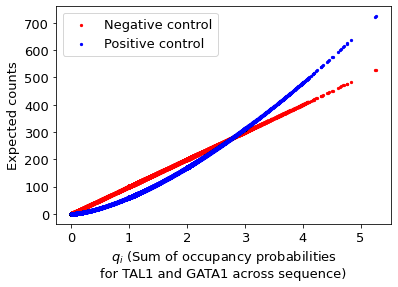

In [31]:
%matplotlib inline

plt.rc('font', size=13)
handles = []
handles.append(plt.scatter(test_sum_gata_and_tal_probs, test_expected_count_neg, color="red", s=5))
handles.append(plt.scatter(test_sum_gata_and_tal_probs, test_expected_count_pos, color="blue", s=5))
plt.xlabel("$q_i$ (Sum of occupancy probabilities\nfor TAL1 and GATA1 across sequence)")
plt.ylabel("Expected counts")
plt.legend(handles, ["Negative control", "Positive control"])
plt.show()

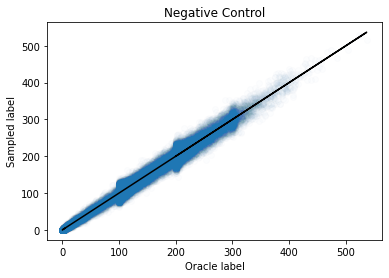

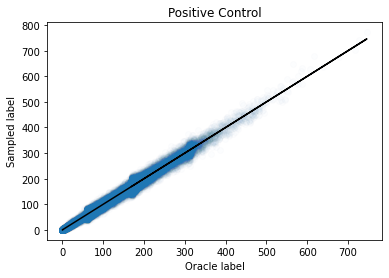

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(train_expected_count_neg, train_expected_count_neg, color="black")
plt.scatter(train_expected_count_neg, train_labels_neg, alpha=0.01)
plt.title("Negative Control")
plt.xlabel("Oracle label")
plt.ylabel("Sampled label")
plt.show()

plt.plot(train_expected_count_pos, train_expected_count_pos, color="black")
plt.scatter(train_expected_count_pos, train_labels_pos, alpha=0.01)
plt.title("Positive Control")
plt.xlabel("Oracle label")
plt.ylabel("Sampled label")
plt.show()

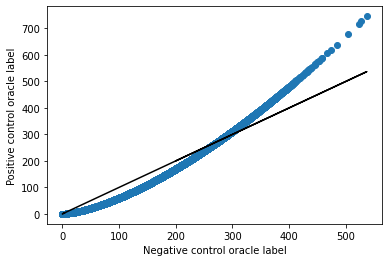

In [10]:
plt.plot(train_expected_count_neg, train_expected_count_neg, color="black")
plt.xlabel("Negative control oracle label")
plt.ylabel("Positive control oracle label")
plt.scatter(train_expected_count_neg, train_expected_count_pos)
plt.show()

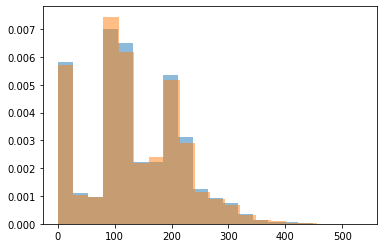

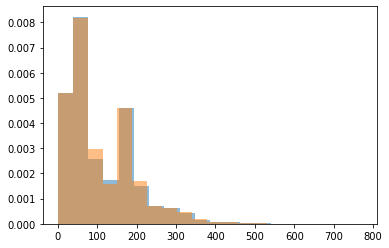

In [11]:
plt.hist(train_labels_neg, density=True, alpha=0.5, bins=20)
plt.hist(test_labels_neg, density=True, alpha=0.5, bins=20)
plt.show()

plt.hist(train_labels_pos, density=True, alpha=0.5, bins=20)
plt.hist(test_labels_pos, density=True, alpha=0.5, bins=20)
plt.show()

In [0]:
def save_labels(filename, exp_count, labels):
  labels_fh = open(filename, "w")
  labels_fh.write("\n".join([str(lab)+"\t"+str(exp) for (exp, lab)
                      in zip(exp_count, labels)]))
  labels_fh.close()  

save_labels("train_neg_labels.txt", train_expected_count_neg, train_labels_neg)
save_labels("train_pos_labels.txt", train_expected_count_pos, train_labels_pos)
save_labels("test_neg_labels.txt", test_expected_count_neg, test_labels_neg)
save_labels("test_pos_labels.txt", test_expected_count_pos, test_labels_pos)

Prep the "knocked out" sequences

In [0]:

def is_separation_valid(gata_start, tal_start):
  #separation_needed is the separation needed between
  # motifs so that there's no ground-truth interaction
  separation_needed = max(len(pwm_TAL), len(pwm_GATA))-1
  return ((gata_start-tal_start >= len(pwm_TAL)+separation_needed) or
          (tal_start-gata_start >= len(pwm_GATA)+separation_needed))
  
def sample_gata_and_tal_positions(seqlen, rng):
  while True:
    gata_start = rng.randint(0, (seqlen-len(pwm_GATA)+1))
    tal_start = rng.randint(0, (seqlen-len(pwm_TAL)+1))
    if is_separation_valid(gata_start=gata_start, tal_start=tal_start):
      return (gata_start, tal_start)

def get_indices_and_motif_positions_to_analyze(embeddings_list, onehot_data):
  rng = np.random.RandomState(1234)
  #only consider sequences 
  toanalyze_info = []
  toanalyze_info_control = [] #also get random positions as a control
  for i in range(len(embeddings_list)):
    embeddings = embeddings_list[i]
    if (len(embeddings)==2):
      if embeddings[0].what.stringDescription=="GATA_disc1":
        assert embeddings[1].what.stringDescription=="TAL1_known1"
        gata_start = embeddings[0].startPos
        tal_start = embeddings[1].startPos
      else:
        assert embeddings[0].what.stringDescription=="TAL1_known1"
        assert embeddings[1].what.stringDescription=="GATA_disc1"
        gata_start = embeddings[1].startPos
        tal_start = embeddings[0].startPos
      if is_separation_valid(gata_start=gata_start, tal_start=tal_start):
        gata_onehot = onehot_data[i][gata_start:gata_start+len(pwm_GATA)]
        tal_onehot = onehot_data[i][tal_start:tal_start+len(pwm_TAL)]
        gata_score = np.sum(pwm_GATA*gata_onehot)
        tal_score = np.sum(pwm_TAL*tal_onehot)
        if (gata_score < -2 and tal_score < -2):
          toanalyze_info.append( (i, gata_start, tal_start) )
          
          #Get randomly sampled positions
          new_gata_start, new_tal_start = sample_gata_and_tal_positions(
              seqlen=len(onehot_data[i]), rng=rng)
          toanalyze_info_control.append( (i, new_gata_start, new_tal_start) )
  return toanalyze_info, toanalyze_info_control


def sample_onehot(len, rng):
  sampled_onehot = []
  for i in range(len):
    arr = [0,0,0,0]
    arr[rng.randint(0, 4)] = 1
    sampled_onehot.append(arr)
  return np.array(sampled_onehot)


def get_low_scoring_pwm_instance(pwm, rng):
  score = None
  while True:
    sampled_onehot = sample_onehot(len=len(pwm), rng=rng)
    score = np.sum(pwm*sampled_onehot)
    if (score > 10):
      break
  return sampled_onehot


def get_toanalyze_data(toanalyze_info, onehot_data, labels_pos, labels_neg):

  rng = np.random.RandomState(1234)
  toanalyze_bothoff = []
  toanalyze_gataoff = []
  toanalyze_taloff = []
  toanalyze_orig = []
  toanalyze_orig_neg_labels = []
  toanalyze_orig_pos_labels = []

  for test_idx, gata_start, tal_start in toanalyze_info:
    onehot = onehot_data[test_idx]
    toanalyze_orig_neg_labels.append(labels_neg[test_idx])
    toanalyze_orig_pos_labels.append(labels_pos[test_idx])
    tal_replacement = get_low_scoring_pwm_instance(pwm=pwm_TAL, rng=rng)
    gata_replacement = get_low_scoring_pwm_instance(pwm=pwm_GATA, rng=rng)
    tal_off = np.array(onehot)
    tal_off[tal_start:tal_start+len(pwm_TAL)] = tal_replacement
    gata_off = np.array(onehot)
    gata_off[gata_start:gata_start+len(pwm_GATA)] = gata_replacement    
    both_off = np.array(gata_off)
    both_off[tal_start:tal_start+len(pwm_TAL)] = tal_replacement
    toanalyze_orig.append(onehot)
    toanalyze_taloff.append(tal_off)
    toanalyze_gataoff.append(gata_off)
    toanalyze_bothoff.append(both_off)

  (toanalyze_orig, toanalyze_taloff, toanalyze_gataoff, toanalyze_bothoff,
   toanalyze_orig_neg_labels, toanalyze_orig_pos_labels) =(
    np.array(toanalyze_orig), np.array(toanalyze_taloff),
    np.array(toanalyze_gataoff), np.array(toanalyze_bothoff),
    np.array(toanalyze_orig_neg_labels), np.array(toanalyze_orig_pos_labels) )
   
  return (toanalyze_orig, toanalyze_taloff, toanalyze_gataoff,
           toanalyze_bothoff, toanalyze_orig_neg_labels,
           toanalyze_orig_pos_labels)

In [0]:
test_toanalyze_info, controltest_toanalyze_info =\
  get_indices_and_motif_positions_to_analyze(
      embeddings_list=test_data.embeddings,
      onehot_data=test_onehot_data)

(test_toanalyze_orig, test_toanalyze_taloff,
 test_toanalyze_gataoff, test_toanalyze_bothoff, test_toanalyze_orig_neg_labels,
 test_toanalyze_orig_pos_labels) = get_toanalyze_data(
     toanalyze_info=test_toanalyze_info,
     onehot_data=test_onehot_data,
     labels_pos=test_labels_pos,
     labels_neg=test_labels_neg)

(controltest_toanalyze_orig,
 controltest_toanalyze_taloff,
 controltest_toanalyze_gataoff,
 controltest_toanalyze_bothoff,
 controltest_toanalyze_orig_neg_labels,
 controltest_toanalyze_orig_pos_labels) = get_toanalyze_data(
     toanalyze_info=controltest_toanalyze_info,
     onehot_data=test_onehot_data,
     labels_pos=test_labels_pos,
     labels_neg=test_labels_neg)
 
assert np.max(np.abs(controltest_toanalyze_orig-test_toanalyze_orig))==0
assert np.max(np.abs(controltest_toanalyze_orig_neg_labels
                       -test_toanalyze_orig_neg_labels))==0
assert np.max(np.abs(controltest_toanalyze_orig_pos_labels
                       -test_toanalyze_orig_pos_labels))==0


train_set_size=int(0.8*len(train_onehot_data))
train_toanalyze_info, controltrain_toanalyze_info =\
  get_indices_and_motif_positions_to_analyze(
                        embeddings_list=train_data.embeddings[:train_set_size],
                        onehot_data=train_onehot_data[:train_set_size])

(train_toanalyze_orig, train_toanalyze_taloff,
 train_toanalyze_gataoff, train_toanalyze_bothoff,
 train_toanalyze_orig_neg_labels, train_toanalyze_orig_pos_labels) = get_toanalyze_data(
     toanalyze_info=train_toanalyze_info,
     onehot_data=train_onehot_data[:train_set_size],
     labels_pos=train_labels_pos[:train_set_size],
     labels_neg=train_labels_neg[:train_set_size])
 
(controltrain_toanalyze_orig,
 controltrain_toanalyze_taloff,
 controltrain_toanalyze_gataoff,
 controltrain_toanalyze_bothoff,
 controltrain_toanalyze_orig_neg_labels,
 controltrain_toanalyze_orig_pos_labels) = get_toanalyze_data(
     toanalyze_info=controltrain_toanalyze_info,
     onehot_data=train_onehot_data,
     labels_pos=train_labels_pos,
     labels_neg=train_labels_neg)
 
assert np.max(np.abs(controltrain_toanalyze_orig-train_toanalyze_orig))==0
assert np.max(np.abs(controltrain_toanalyze_orig_neg_labels
                       -train_toanalyze_orig_neg_labels))==0
assert np.max(np.abs(controltrain_toanalyze_orig_pos_labels
                       -train_toanalyze_orig_pos_labels))==0


In [15]:
#sanity check the labels/expected

def sanity_check(toanalyze_orig, toanalyze_taloff, toanalyze_gataoff,
                 toanalyze_bothoff, toanalyze_orig_neg_labels=None,
                 toanalyze_orig_pos_labels=None):

  print("Numbed in toanalyze_orig", len(toanalyze_orig))

  (toanalyze_orig_expected_count_neg,
  toanalyze_orig_expected_count_pos) =\
    get_oracle_preds(toanalyze_orig)
  (toanalyze_gataoff_expected_count_neg,
  toanalyze_gataoff_expected_count_pos) =\
    get_oracle_preds(toanalyze_gataoff)
  (toanalyze_taloff_expected_count_neg,
  toanalyze_taloff_expected_count_pos) =\
    get_oracle_preds(toanalyze_taloff)
  (toanalyze_bothoff_expected_count_neg,
  toanalyze_bothoff_expected_count_pos) =\
    get_oracle_preds(toanalyze_bothoff)

  if (toanalyze_orig_neg_labels is not None):  
    plt.plot(toanalyze_orig_expected_count_neg,
            toanalyze_orig_expected_count_neg,
            color="black")
    plt.scatter(toanalyze_orig_expected_count_neg,
                toanalyze_orig_neg_labels)
    plt.show()
  if (toanalyze_orig_pos_labels is not None):
    plt.plot(toanalyze_orig_expected_count_pos,
            toanalyze_orig_expected_count_pos,
            color="black")
    plt.scatter(toanalyze_orig_expected_count_pos,
                toanalyze_orig_pos_labels)
    plt.show()
  
  plt.plot(toanalyze_orig_expected_count_neg,
          toanalyze_orig_expected_count_neg,
          color="black")
  plt.scatter(toanalyze_orig_expected_count_neg,
              toanalyze_orig_expected_count_pos)
  plt.show()

  #sanity check negative control and positive control interactions
  groundtruth_gatacontrib_neg = (toanalyze_taloff_expected_count_neg -
                                toanalyze_bothoff_expected_count_neg)
  groundtruth_talcontrib_neg = (toanalyze_gataoff_expected_count_neg -
                                toanalyze_bothoff_expected_count_neg)
  groundtruth_jointcontrib_neg = (toanalyze_orig_expected_count_neg -
                                  toanalyze_bothoff_expected_count_neg)

  groundtruth_gatacontrib_pos = (toanalyze_taloff_expected_count_pos -
                                toanalyze_bothoff_expected_count_pos)
  groundtruth_talcontrib_pos = (toanalyze_gataoff_expected_count_pos -
                                toanalyze_bothoff_expected_count_pos)
  groundtruth_jointcontrib_pos = (toanalyze_orig_expected_count_pos -
                                  toanalyze_bothoff_expected_count_pos)

  groundtruth_neg_maineff = (groundtruth_gatacontrib_neg
                             + groundtruth_talcontrib_neg)

  groundtruth_neg_interactions = (groundtruth_jointcontrib_neg -
    (groundtruth_gatacontrib_neg + groundtruth_talcontrib_neg))
  groundtruth_pos_interactions = (groundtruth_jointcontrib_pos -
    (groundtruth_gatacontrib_pos + groundtruth_talcontrib_pos))

  print("max neg control interaction:", max(groundtruth_neg_interactions))
  assert max(groundtruth_neg_interactions) < 1e-7

  plt.hist(groundtruth_pos_interactions, density=True, bins=20)
  plt.title("pos control interactions")
  plt.show()

  return (toanalyze_orig_expected_count_neg,
          toanalyze_orig_expected_count_pos,
          groundtruth_pos_interactions,
          groundtruth_neg_maineff)


print("test set sanity check:")
(test_toanalyze_groundtruth_orig_neg,
 test_toanalyze_groundtruth_orig_pos,
 test_toanalyze_groundtruth_pos_interactions,
 test_toanalyze_groundtruth_neg_maineff) = sanity_check(
             toanalyze_orig=test_toanalyze_orig,
             toanalyze_taloff=test_toanalyze_taloff,
             toanalyze_gataoff=test_toanalyze_gataoff,
             toanalyze_bothoff=test_toanalyze_bothoff,
             toanalyze_orig_neg_labels=test_toanalyze_orig_neg_labels,
             toanalyze_orig_pos_labels=test_toanalyze_orig_pos_labels)

print("controltest set sanity check:")
_ = sanity_check(toanalyze_orig=controltest_toanalyze_orig,
             toanalyze_taloff=controltest_toanalyze_taloff,
             toanalyze_gataoff=controltest_toanalyze_gataoff,
             toanalyze_bothoff=controltest_toanalyze_bothoff,
             toanalyze_orig_neg_labels=controltest_toanalyze_orig_neg_labels,
             toanalyze_orig_pos_labels=controltest_toanalyze_orig_pos_labels)

print("train set sanity check:")
_ = sanity_check(toanalyze_orig=train_toanalyze_orig,
             toanalyze_taloff=train_toanalyze_taloff,
             toanalyze_gataoff=train_toanalyze_gataoff,
             toanalyze_bothoff=train_toanalyze_bothoff,
             toanalyze_orig_neg_labels=train_toanalyze_orig_neg_labels,
             toanalyze_orig_pos_labels=train_toanalyze_orig_pos_labels)

print("controltrain set sanity check:")
_ = sanity_check(toanalyze_orig=controltrain_toanalyze_orig,
             toanalyze_taloff=controltrain_toanalyze_taloff,
             toanalyze_gataoff=controltrain_toanalyze_gataoff,
             toanalyze_bothoff=controltrain_toanalyze_bothoff,
             toanalyze_orig_neg_labels=controltrain_toanalyze_orig_neg_labels,
             toanalyze_orig_pos_labels=controltrain_toanalyze_orig_pos_labels)

test set sanity check:
Numbed in toanalyze_orig 7971


ValueError: ignored

Write out the info pertaining to the sequences to analyze

In [0]:
acgt_string = "ACGT"


def onehots_to_seqs(onehots):
  return ["".join([acgt_string[acgt_idx] for acgt_idx in x])
          for x in np.argmax(onehots, axis=-1)]


def write_arr_to_file(arr, filename):
  with open(filename,'w') as fh:
    fh.write("\n".join([str(x) for x in arr]))


write_arr_to_file(arr=onehots_to_seqs(test_toanalyze_orig),
                  filename="test_toanalyze_orig_seqs.txt")
write_arr_to_file(arr=onehots_to_seqs(test_toanalyze_gataoff),
                  filename="test_toanalyze_gataoff_seqs.txt")
write_arr_to_file(arr=onehots_to_seqs(test_toanalyze_taloff),
                  filename="test_toanalyze_taloff_seqs.txt")
write_arr_to_file(arr=onehots_to_seqs(test_toanalyze_bothoff),
                  filename="test_toanalyze_bothoff_seqs.txt")

write_arr_to_file(arr=test_toanalyze_orig_neg_labels,
                  filename="test_toanalyze_orig_neg_labels.txt")
write_arr_to_file(arr=test_toanalyze_orig_pos_labels,
                  filename="test_toanalyze_orig_pos_labels.txt")

write_arr_to_file(arr=onehots_to_seqs(controltest_toanalyze_gataoff),
                  filename="controltest_toanalyze_gataoff_seqs.txt")
write_arr_to_file(arr=onehots_to_seqs(controltest_toanalyze_taloff),
                  filename="controltest_toanalyze_taloff_seqs.txt")
write_arr_to_file(arr=onehots_to_seqs(controltest_toanalyze_bothoff),
                  filename="controltest_toanalyze_bothoff_seqs.txt")

write_arr_to_file(arr=test_toanalyze_groundtruth_orig_neg,
                  filename="test_toanalyze_groundtruth_orig_neg.txt")
write_arr_to_file(arr=test_toanalyze_groundtruth_orig_pos,
                  filename="test_toanalyze_groundtruth_orig_pos.txt")
write_arr_to_file(arr=test_toanalyze_groundtruth_pos_interactions,
                  filename="test_toanalyze_groundtruth_pos_interactions.txt")
write_arr_to_file(arr=test_toanalyze_groundtruth_neg_maineff,
                  filename="test_toanalyze_groundtruth_neg_maineff.txt")

write_arr_to_file(arr=onehots_to_seqs(train_toanalyze_orig),
                  filename="train_toanalyze_orig_seqs.txt")
write_arr_to_file(arr=onehots_to_seqs(train_toanalyze_gataoff),
                  filename="train_toanalyze_gataoff_seqs.txt")
write_arr_to_file(arr=onehots_to_seqs(train_toanalyze_taloff),
                  filename="train_toanalyze_taloff_seqs.txt")
write_arr_to_file(arr=onehots_to_seqs(train_toanalyze_bothoff),
                  filename="train_toanalyze_bothoff_seqs.txt")

write_arr_to_file(arr=train_toanalyze_orig_neg_labels,
                  filename="train_toanalyze_orig_neg_labels.txt")
write_arr_to_file(arr=train_toanalyze_orig_pos_labels,
                  filename="train_toanalyze_orig_pos_labels.txt")

write_arr_to_file(arr=onehots_to_seqs(controltrain_toanalyze_gataoff),
                  filename="controltrain_toanalyze_gataoff_seqs.txt")
write_arr_to_file(arr=onehots_to_seqs(controltrain_toanalyze_taloff),
                  filename="controltrain_toanalyze_taloff_seqs.txt")
write_arr_to_file(arr=onehots_to_seqs(controltrain_toanalyze_bothoff),
                  filename="controltrain_toanalyze_bothoff_seqs.txt")


In [0]:
!pip install deeplift

In [0]:
from deeplift.dinuc_shuffle import dinuc_shuffle
#similarly create a bunch of shuffled sequences to see how
# that behaves as a control

rng = np.random.RandomState(1234)
shuff_toanalyze_bothoff = []
shuff_toanalyze_gataoff = []
shuff_toanalyze_taloff = []
shuff_toanalyze_orig = []

for test_idx, gata_start, tal_start in test_toanalyze_info:
  onehot = dinuc_shuffle(test_onehot_data[test_idx], rng=rng)
  tal_replacement = sample_onehot(len=len(pwm_TAL), rng=rng)
  gata_replacement = sample_onehot(len=len(pwm_GATA), rng=rng)
  tal_off = np.array(onehot)
  tal_off[tal_start:tal_start+len(pwm_TAL)] = tal_replacement
  gata_off = np.array(onehot)
  gata_off[gata_start:gata_start+len(pwm_GATA)] = gata_replacement    
  both_off = np.array(gata_off)
  both_off[tal_start:tal_start+len(pwm_TAL)] = tal_replacement
  shuff_toanalyze_orig.append(onehot)
  shuff_toanalyze_taloff.append(tal_off)
  shuff_toanalyze_gataoff.append(gata_off)
  shuff_toanalyze_bothoff.append(both_off)

(shuff_toanalyze_orig, shuff_toanalyze_taloff,
 shuff_toanalyze_gataoff, shuff_toanalyze_bothoff) =(
  np.array(shuff_toanalyze_orig), np.array(shuff_toanalyze_taloff),
  np.array(shuff_toanalyze_gataoff), np.array(shuff_toanalyze_bothoff))
 
 

In [0]:
(shuff_toanalyze_orig_expected_count_neg,
 shuff_toanalyze_orig_expected_count_pos) =\
  get_oracle_preds(shuff_toanalyze_orig)

In [0]:
sanity_check(toanalyze_orig=shuff_toanalyze_orig,
             toanalyze_taloff=shuff_toanalyze_taloff,
             toanalyze_gataoff=shuff_toanalyze_gataoff,
             toanalyze_bothoff=shuff_toanalyze_bothoff,
             toanalyze_orig_neg_labels=None,
             toanalyze_orig_pos_labels=None)


In [0]:
#Another sanity check...what are the labels on the shuff sequences
plt.hist(shuff_toanalyze_orig_expected_count_neg, density=True, bins=20)
plt.title("Shuff labels")
plt.show()

In [0]:
write_arr_to_file(arr=onehots_to_seqs(shuff_toanalyze_orig),
                  filename="shuff_toanalyze_orig_seqs.txt")
write_arr_to_file(arr=onehots_to_seqs(shuff_toanalyze_gataoff),
                  filename="shuff_toanalyze_gataoff_seqs.txt")
write_arr_to_file(arr=onehots_to_seqs(shuff_toanalyze_taloff),
                  filename="shuff_toanalyze_taloff_seqs.txt")
write_arr_to_file(arr=onehots_to_seqs(shuff_toanalyze_bothoff),
                  filename="shuff_toanalyze_bothoff_seqs.txt")
write_arr_to_file(arr=shuff_toanalyze_orig_expected_count_neg,
                  filename="shuff_toanalyze_orig_oraclepred_neg.txt")
write_arr_to_file(arr=shuff_toanalyze_orig_expected_count_pos,
                  filename="shuff_toanalyze_orig_oraclepred_pos.txt")

In [0]:
!head train_neg_labels.txt

In [0]:
!head train_pos_labels.txt

In [0]:
!gzip -f *.txt
!gzip -f *.simdata

!du -h *

In [0]:
from google.colab import files
files.download("train_simulation.simdata.gz")
files.download("train_neg_labels.txt.gz")
files.download("train_pos_labels.txt.gz")

files.download("test_simulation.simdata.gz")
files.download("test_neg_labels.txt.gz")
files.download("test_pos_labels.txt.gz")

files.download("test_toanalyze_orig_seqs.txt.gz")
files.download("test_toanalyze_taloff_seqs.txt.gz")
files.download("test_toanalyze_gataoff_seqs.txt.gz")
files.download("test_toanalyze_bothoff_seqs.txt.gz")

files.download("test_toanalyze_orig_pos_labels.txt.gz")
files.download("test_toanalyze_orig_neg_labels.txt.gz")

files.download("test_toanalyze_groundtruth_orig_neg.txt.gz")
files.download("test_toanalyze_groundtruth_orig_pos.txt.gz")
files.download("test_toanalyze_groundtruth_pos_interactions.txt.gz")
files.download("test_toanalyze_groundtruth_neg_maineff.txt.gz")


files.download("controltest_toanalyze_taloff_seqs.txt.gz")
files.download("controltest_toanalyze_gataoff_seqs.txt.gz")
files.download("controltest_toanalyze_bothoff_seqs.txt.gz")

files.download("train_toanalyze_orig_seqs.txt.gz")
files.download("train_toanalyze_taloff_seqs.txt.gz")
files.download("train_toanalyze_gataoff_seqs.txt.gz")
files.download("train_toanalyze_bothoff_seqs.txt.gz")

files.download("train_toanalyze_orig_pos_labels.txt.gz")
files.download("train_toanalyze_orig_neg_labels.txt.gz")

files.download("controltrain_toanalyze_taloff_seqs.txt.gz")
files.download("controltrain_toanalyze_gataoff_seqs.txt.gz")
files.download("controltrain_toanalyze_bothoff_seqs.txt.gz")

files.download("shuff_toanalyze_orig_seqs.txt.gz")
files.download("shuff_toanalyze_taloff_seqs.txt.gz")
files.download("shuff_toanalyze_gataoff_seqs.txt.gz")
files.download("shuff_toanalyze_bothoff_seqs.txt.gz")

files.download("shuff_toanalyze_orig_oraclepred_neg.txt.gz")
files.download("shuff_toanalyze_orig_oraclepred_pos.txt.gz")